# LDA Analysis

The <b> purpose</b> of this notebook is to run LDA models to output topics and keywords. The <b> results</b> will be inputted into the Twitter API search feature, but we need to be able to create specific topics to do so. 

## Libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import datetime
import spacy
import re
import json
import os
import matplotlib.pyplot as plt
import matplotlib
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import models
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('wordnet')
import pyLDAvis.gensim
import pickle

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/celinasprague/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing Datasets From Prior Notebook

In [2]:
data = pd.read_csv('finaldata2.csv', dtype = str)

In [3]:
data_colnan=data.columns[data.isnull().any()]
data[data_colnan].isnull().sum()

author                               19247
entities_locations                   20851
entities_organizations               16841
entities_persons                     18445
external_links                       26866
highlightText                        40099
highlightTitle                       40099
rating                               40099
thread_main_image                     1203
thread_performance_score               802
thread_published                       802
thread_replies_count                   802
thread_section_title                 22455
thread_site                            802
thread_site_categories                 802
thread_site_full                       802
thread_site_section                  22455
thread_site_type                      1604
thread_social_facebook_comments       1604
thread_social_facebook_likes          1604
thread_social_facebook_shares         1604
thread_social_gplus_shares            1604
thread_social_linkedin_shares         1604
thread_soci

In [4]:
data['title'] = data['title'].fillna("none")

## Setting Up NLP Helper Functions

In [6]:
data = data.text.values.tolist()

In [7]:
def sent_to_words(sentences):
    
    counter = 0
    start_time = time.time()
    
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        counter += 1
        
        if counter % 10000 == 0:
            print("There have been {} files read so far".format(counter))
            print("Time elapsed: {}".format(time.time() - start_time))
        
    
    print("Operation complete after {} seconds.".format(time.time()-start_time))   

data_words = list(sent_to_words(data))


There have been 10000 files read so far
Time elapsed: 22.652096033096313
There have been 20000 files read so far
Time elapsed: 48.186535120010376
There have been 30000 files read so far
Time elapsed: 69.19865107536316
There have been 40000 files read so far
Time elapsed: 91.62215900421143
Operation complete after 93.58340311050415 seconds.


In [10]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []

    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
        
        
     

    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [11]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [12]:
# Build LDA Model

lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

/Users/celinasprague/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning:

n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21



In [13]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [14]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))


# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -56515547.82838709
Perplexity:  441.69066706765074
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [15]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()


# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 30}
Best Log Likelihood Score:  -17958950.785664637
Model Perplexity:  322.9911092849095


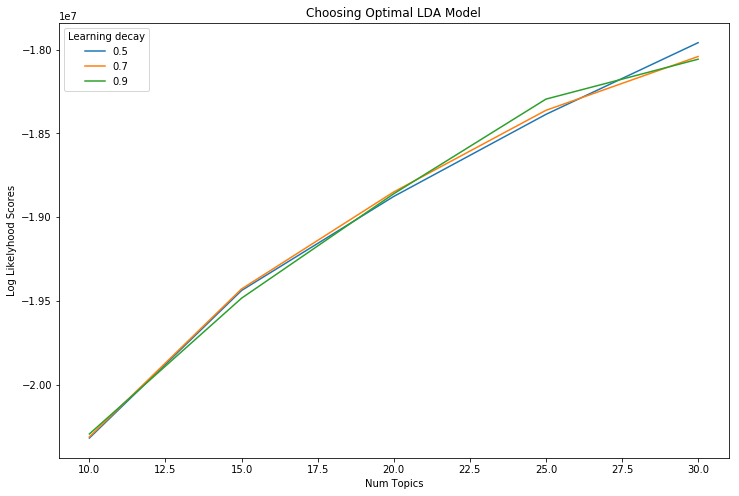

In [17]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [18]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic0", "Topic1", "Topic2", "Topic3", "Topic4", "Topic5", "Topic6", "Topic7", "Topic8", "Topic9", "Topic10", "Topic11", "Topic12", "Topic13", "Topic14", "Topic15", "Topic16", "Topic17", "Topic18", "Topic19", "Topic20", "Topic21", "Topic22", "Topic23", "Topic24", "Topic25", "Topic26", "Topic27", "Topic28", "Topic29"]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)

In [35]:
df_document_topics

KeyboardInterrupt: 

In [33]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.to_csv("topic_distribution.csv")

In [34]:
df_topic_distribution

,Topic Num,Num Documents
0,21,12430
1,0,2005
2,18,2005
3,20,1604
4,16,1604
5,2,1203
6,6,1203
7,8,1203
8,9,1203
9,11,1203


In [29]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.to_csv("Topic_keywords.csv")

In [30]:
df_topic_keywords

,abandon,abc,abcontra,abduction,abel,abide,abilene,ability,abinclusive,abject,...,zbog,zealand,zionist,zjeo,znacajno,zoo,zuckerberg,zvanicni,zvanicnog,zvfrno
Topic0,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,385.099019,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic1,0.033333,0.033333,0.033333,0.033333,0.033333,804.762454,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic2,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,392.006137,0.033333,0.033333,0.033333,0.033333
Topic3,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,810.913218,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic4,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,1618.078452,0.033333,0.033333,0.033333
Topic5,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,806.282050,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic6,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic7,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic8,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,400.933851,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic9,412.973911,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,412.973911,0.033333,0.033333,0.033333,0.033333,0.033333,412.973911


In [31]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.to_csv("topic_keywords2.csv")

In [32]:
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,dog,say,campaign,child,run,care,seize,time,make,year,woman,office,lamandre,police,public,use,agent,dangerous,old,tell
Topic 1,investigation,rcmp,officer,year,crime,law,operation,say,report,break,safety,public,undercover,security,make,time,case,national,official,cbc
Topic 2,police,bradford,shoot,image,mall,kill,gunman,reportedly,emantic,admit,demand,old,friday,year,shooting,demonstrator,say,suspect,remain,people
Topic 3,alert,test,new,ministry,year,people,use,receive,emergency,cellphone,mobile,text,tell,say,website,experience,black,civil,reddit,stuart
Topic 4,facebook,document,cnn,app,kramer,say,court,company,committee,user,collin,public,make,tell,seal,pikini,ask,obtain,legal,friend
Topic 5,overtime,texas,point,lsu,salary,game,yard,mond,conversion,say,throw,team,run,win,pass,play,college,burrow,apo,touchdown
Topic 6,say,vote,sex,espy,mississippi,marriage,voter,lgbt,campaign,people,right,smith,hyde,group,taiwan,black,republican,turnout,result,white
Topic 7,report,tax,irs,write,sex,worker,woman,online,say,illegal,november,man,twitter,income,snapchat,miner,service,girl,nude,city
Topic 8,expenditure,government,say,russian,irregular,report,state,russia,wasteful,year,public,police,general,auditor,department,exercise,military,signal,increase,national
Topic 9,say,migration,christma,london,light,disney,pact,make,migrant,year,road,nccs,singapore,clock,control,nation,breitbart,immigration,united,orchard


# End